In [1]:
%matplotlib inline
import sys
sys.path.insert(1, '/Users/trentonbricken/protein-gen/software/deep_boltzmann')

from PlottingFunctions import *

import os
os.chdir('../software/deep_boltzmann')

from deep_boltzmann.networks.invertible import create_NICERNet, create_RealNVPNet, invnet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.networks.plot import test_xz_projection
from deep_boltzmann.util import count_transitions
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

import seaborn as sns
import matplotlib.pylab as plt

from evcouplings.couplings import CouplingsModel
from EVCouplingsStuff.seq_sele import *

from evc import *

focus_seqs = read_fa('EVCouplingsStuff/DYR_ECOLI_1_b0.5.a2m_trimmed.fa')
evc_model = CouplingsModel('EVCouplingsStuff/DYR.model')
#scores = evc_model.hamiltonians(list(focus_seqs['seq']))

enc_seqs=[]
for seq in focus_seqs['seq']:
    enc_seqs.append(encode_aa(seq, evc_model.alphabet_map)) 

enc_seqs = np.asarray(enc_seqs)
#encode_aa(np.char.upper(ali.matrix[0, :]), a2n)

oh = []
N=20 # none of these focus have gaps, else should be 21.
seq_len = 2 
print('enc seqs before short', enc_seqs.shape)
enc_seqs = enc_seqs[: , :seq_len]
print('enc seqs after short', enc_seqs.shape)
target_seq = enc_seqs[0]
AA_num=N
for seq in enc_seqs:
    oh.append(onehot(seq,N))
oh=np.asarray(oh)

print('the size of oh', oh.shape)

print('calculating weights and identities')
N = oh.shape[0]
L = oh.shape[1]
AA = oh.shape[2]
#w, neighbors = msa_weights(enc_seqs, theta=0.8, pseudocount=0)
print(' shape of the one hots is', oh.shape)

t_oh = oh[0]
#t_oh_flat =t_oh.flatten().reshape(-1,1)
t_seq_aa = enc_seqs[0,:]

h = evc_model.h_i
J = evc_model.J_ij

print('before shortening', h.shape, J.shape)

h = h[0:seq_len, :]
J = J[0:seq_len, 0:seq_len, :,:]

print('after shortening', h.shape, J.shape)

plt.figure()
print('Plotting a hist of all the natural sequences energies:')
plt.hist(hamiltonians(enc_seqs, J, h), bins=100) # used to be oh
plt.show()

gen_model = EVCouplingsGenerator(L, AA, h, J)

plt.figure()
plot_potential(AA_num, target_seq, gen_model.energy, orientation='horizontal', pos1=0, pos2=1)
plt.show()

## Generating data in proportion to the boltzmann dist. 

evh_vals = []
seq_ints = []
for i in range(20):
    for j in range(20):
        seq = np.hstack([i,j])
        seq = seq.reshape(1,-1)
        ham = gen_model.energy(seq)[0]
        #print(ham)
        evh_vals.append(ham)
        seq_ints.append(seq)
vals = evh_vals
probs = np.exp(vals) / np.sum(np.exp(vals))
inds= np.argsort(probs)
ps = np.sort(probs)
ev_vals = np.asarray(evh_vals)[inds]
seq_sort = np.asarray(seq_ints)[inds]
cum =np.cumsum(ps)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
rand_samples=10000
rands = np.random.uniform(0,1,rand_samples)

samp_seqs = []
for r in rands:
    nearest_prob_ind = find_nearest(cum, r)
    nearest_score = ev_vals[nearest_prob_ind]
    nearest_seq = seq_sort[nearest_prob_ind]
    samp_seqs.append(nearest_seq)

samp_seqs = np.asarray(samp_seqs).reshape(rand_samples, -1)




/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/trentonbricken/anaconda3/lib/python3.7/site-pack

enc seqs before short (7848, 155)
enc seqs after short (7848, 2)
the size of oh (7848, 2, 20)
calculating weights and identities
 shape of the one hots is (7848, 2, 20)
before shortening (155, 20) (155, 155, 20, 20)
after shortening (2, 20) (2, 2, 20, 20)
Plotting a hist of all the natural sequences energies:
changing only two amino acid positions: pos1= 0  pos2= 1
(400, 2)
(400,)


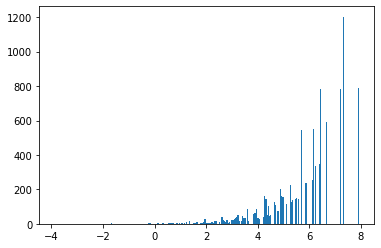

In [2]:

scores = gen_model.energy(samp_seqs)
plt.hist(scores, bins=250)
plt.show()

In [3]:
samp_seqs[0,:]

array([11,  7])

In [4]:
dequantize=True

In [7]:
h = evc_model.h_i
J = evc_model.J_ij

print('before shortening', h.shape, J.shape)

h = h[0:seq_len, :]
J = J[0:seq_len, 0:seq_len, :,:]

before shortening (155, 20) (155, 155, 20, 20)


In [60]:
from scipy.special import softmax
if dequantize:

    def make_oh(model):
        fa_chars = ''.join(model.alphabet)
        oh_mat = dict(zip(fa_chars, np.eye(len(fa_chars))))
        return oh_mat

    one_hot_mat = make_oh(evc_model)
    
    def single_mut_profile(seqs, h, J):
        # load model parameters
        oh = []
        for s in seqs:
            x_temp = onehot(s, AA)
            oh.append(x_temp)
        oh = np.asarray(oh)
        #h,J = model.h_i, model.J_ij.transpose(0, 2, 1, 3)
        J = J.transpose(0,2,1,3)
        # total energy contribution to each site i (hia + sum_j[Jia,jb])
        PW_i = h + np.einsum('likj,nkj->nli', J, oh)/2
        softm = softmax(PW_i, axis=-1)
        
        return softm
    
    res = single_mut_profile(samp_seqs, h, J)


In [63]:
res.shape

(10000, 2, 20)

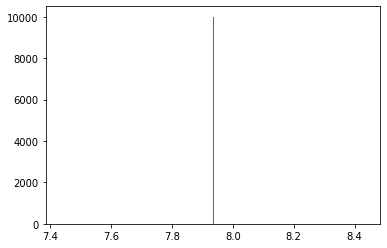

In [64]:
scores = gen_model.energy(res.reshape(res.shape[0], -1)) # makes each sequence much more likely. 
plt.hist(scores, bins=250)
plt.show()

In [66]:
h = evc_model.h_i
J = evc_model.J_ij

print('before shortening', h.shape, J.shape)

h = h[0:seq_len, :]
J = J[0:seq_len, 0:seq_len, :,:]

before shortening (155, 20) (155, 155, 20, 20)


In [68]:
def hamiltonians(seqs, J, h):
    if len(seqs.shape) ==3:
        seqs = seqs.reshape(seqs.shape[0], -1) # in case the onehots arent already flat. 
    J = np.moveaxis(J, 1,2)
    J = J.reshape(seqs.shape[-1], seqs.shape[-1])
    h = h.reshape(-1)
    #print(J.shape, h.shape, seqs.shape)
    H = ((seqs.T*(J@seqs.T))/2 ).T.sum(1) + seqs@h
    return H # before it was an array of an array. 


hams = hamiltonians(res, J, h)

In [73]:
res[3].sum()

2.0

In [70]:
hams.shape

(10000,)

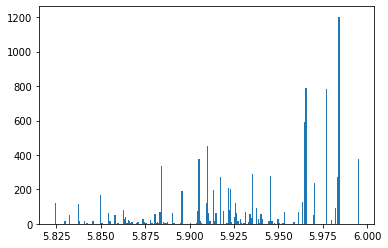

In [71]:

plt.hist(hams, bins=250) # dequant and makes everything much more average. 
plt.show()

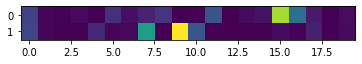

In [58]:
plt.imshow(res[0,:,:])

In [33]:
np.arange(-10,10)

array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
         3,   4,   5,   6,   7,   8,   9])

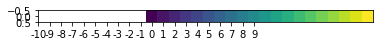

In [47]:
ax = plt.figure().add_subplot(111)
plt.imshow(np.arange(-10,10,1).reshape((1,-1)))
plt.xticks(np.arange(-10,10,1), np.arange(-10,10,1))
plt.show()

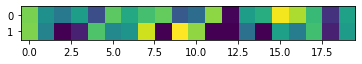

In [59]:
plt.imshow(np.log10(res[0,:,:])) # this is the softmax of both

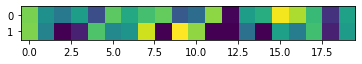

In [25]:
plt.imshow(np.log10(res[0].T)) # yellow is more positive

In [27]:
np.log10(res[0].T)

array([[-1.07848457, -2.0974692 , -2.44533328, -1.89674668, -3.01646169,
        -1.24889192, -1.7506428 , -1.40250502, -1.19473097, -2.87121397,
        -2.62005356, -0.96077578, -3.80511085, -1.90102997, -1.68297886,
        -0.43696678, -0.80663132, -1.5052172 , -3.33245681, -1.8650184 ],
       [-1.04274548, -2.28829022, -3.84582688, -3.52332031, -1.32560231,
        -2.20715106, -2.0512878 , -0.62760549, -3.84582688, -0.37402374,
        -0.94688076, -3.84582688, -3.84582688, -2.53545351, -3.84582688,
        -1.87953319, -2.38474217, -1.42932652, -3.52431257, -1.92996253]])